# Import dependencies

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import Callback
from keras import regularizers
from keras import optimizers

from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import *

import numpy as np

In [2]:
import tensorflow as tf
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

# Generate data

In [3]:
# Dot count 
samples = 1000
test_n = 200

In [4]:
# X interval
x_int = (-9, 9)
# Y interval
y_int = (-1, 1)

In [5]:
# Generate
data = [(np.random.random() * (x_int[1] - x_int[0]) + x_int[0], 
                  np.random.random() * (y_int[1] - y_int[0]) + y_int[0]) for i in range(samples + test_n)]
#print(data)
train_data = np.array(data[test_n:])
test_data = np.array(data[:test_n])
print(train_data)

[[-7.14377036  0.80510581]
 [ 0.0945427   0.65291493]
 [-3.23910718  0.79104646]
 ...
 [ 7.02174663 -0.30824508]
 [-6.21972455 -0.94910448]
 [ 2.62480295  0.27380463]]


In [6]:

# Your variant function
def main_func(x):
    return np.cos(x)
def main_func_noisy(x):
    return main_func(x) + np.cos(4*x + 1) / 5

def result_func(xy):
    return main_func(xy[0]) > xy[1]

def result_func_noisy(xy):
    return main_func_noisy(xy[0]) > xy[1]

In [7]:
train_answers = np.apply_along_axis(result_func_noisy, arr=train_data, axis=1)
#answers = np.reshape(answers, (samples,1))
print(train_answers.shape)

test_answers = np.apply_along_axis(result_func, arr=test_data, axis=1)
print(test_answers.shape)

(1000,)
(200,)


In [8]:
train_data_true = train_data[train_answers]
train_data_false = train_data[np.logical_not(train_answers)]
print(train_data_true.shape)
print(train_data_false.shape)

(493, 2)
(507, 2)


## Plot drawing

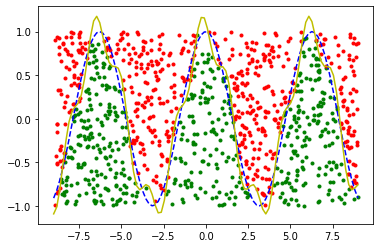

In [9]:
fig, ax = plt.subplots()

xx = np.linspace(*x_int, 100)

ax.plot(train_data_true[:,0], train_data_true[:,1], 'g.')
ax.plot(train_data_false[:,0], train_data_false[:,1], 'r.')
ax.plot(xx, main_func(xx), 'b--')
ax.plot(xx, main_func_noisy(xx), 'y-')

## Experimentation

Plot drawing

In [10]:
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Setting parameters and contur plot drawing

In [11]:
def plot_contour_graph(model):
    xx = np.linspace(*x_int, 100)
    yy = np.linspace(*y_int, 200)

    xm, ym = np.meshgrid(xx, yy)
    xys = np.array([xm, ym]).reshape((2, -1))

    z_actual = result_func(xys).reshape(200,100)

    xys = np.moveaxis(xys, 0, 1)
    z = model.predict(xys).reshape(200, 100)

    
    plt.contourf(xm, ym, z)
    plt.title('Neural net vision of the function')
    plt.colorbar()
    plt.show()
    
    plt.contourf(xm, ym, z_actual)
    plt.title('Actual function')
    plt.colorbar()
    plt.show()

In [12]:
style = {'description_width': 'initial'}
@interact_manual(
    n_layers = IntSlider(min=0, max=4, value=2, description='Слоев: '),
    layer1_size = IntSlider(min=0, max=20, value=6, description='Neurons count in layer 1: ', style=style),
    layer2_size = IntSlider(min=0, max=20, value=3, description='Neurons count in layer 2: ', style=style),
    layer3_size = IntSlider(min=0, max=20, value=0, description='Neurons count in layer 1: ', style=style),
    layer4_size = IntSlider(min=0, max=20, value=0, description='Neurons count in layer 1: ', style=style),
    layer1_type = Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 1 activation type: ', style=style),
    layer2_type = Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 2 activation type: ', style=style),
    layer3_type = Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 3 activation type: ', style=style),
    layer4_type = Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 4 activation type: ', style=style),
    layer_out_type = Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='sigmoid',
                          description='Output layer activation type: ', style=style),
    loss_func = Dropdown(options={
        'Standard deviation': 'mse', 
        'Mean absolute deviation': 'mae',
        'Binary crossentropy': 'binary_crossentropy'
    }, value='binary_crossentropy', description='Loss function: ', style=style),
    epochs = IntSlider(min=10, max=10000, step=10, value=300, description='Epoch count: ', style=style),
    batch_size = IntSlider(min=0, max=len(data), value=100, description='Batch size: ', style=style),
    lr = ToggleButtons(options=["-0.1", "0", "0.001", "0.01", "0.05", "0.1", "0.5", "1", "5"], 
                               value="0.01", description='Learn rate: ', style=style),
    l1=ToggleButtons(options=["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], 
                               value="0.0001", description='Regularization  L1: ', style=style),
    l2=ToggleButtons(options=["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], 
                               value="0.0001", description='Regularization  L2: ', style=style)
)
def interactive_learning(n_layers, loss_func, batch_size, lr, l1, l2, layer_out_type, epochs,
                         layer1_size, layer2_size, layer3_size, layer4_size,
                         layer1_type, layer2_type, layer3_type, layer4_type):
    layer_sizes = [layer1_size, layer2_size, layer3_size, layer4_size]
    layer_types = [layer1_type, layer2_type, layer3_type, layer4_type]
    lr = float(lr)
    l1 = float(l1)
    l2 = float(l2)
    
    model = Sequential()
    
    if n_layers == 0:
        model.add(Dense(1, activation=layer_out_type, 
                        input_shape=(2,), kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    else:
        model.add(Dense(layer_sizes[0], activation=layer_types[0], 
                        input_shape=(2,), kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
        for i in range(1, n_layers):
            model.add(Dense(layer_sizes[i], activation=layer_types[i],
                           kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
        model.add(Dense(1, activation=layer_out_type, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    
    model.compile(
     optimizer = optimizers.SGD(learning_rate=lr),
     loss = loss_func,
     metrics = ["accuracy"]
    )
    
    
    history = model.fit(
     train_data, train_answers,
     epochs=epochs,
     batch_size=batch_size,
     validation_data=(test_data, test_answers),
     verbose=0
    )
    
    #print('Accuracy: ', history.history['val_accuracy'][-1])
    #plot_accuracy(history)
    #plot_contour_graph(model)
    return history.history['val_accuracy'][-1], history, model

interactive(children=(IntSlider(value=2, description='Слоев: ', max=4), Dropdown(description='Loss function: '…

In [14]:
tab = []
tab_hist = []
tab_model = []
for lr in ["-0.1", "0", "0.001", "0.01", "0.05", "0.1", "0.5", "1", "5"]:
    line = []
    line_hist = []
    line_model = []
    for L1 in ["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"]:
        acc, hist, model = interactive_learning(n_layers=2, loss_func='binary_crossentropy', batch_size=100, lr=lr, l1=L1, l2='0.0001', layer_out_type='sigmoid', epochs=300,
                         layer1_size=6, layer2_size=3, layer3_size=0, layer4_size=0,
                         layer1_type='relu', layer2_type='relu', layer3_type='relu', layer4_type='relu')
        line_hist.append(hist)
        line_model.append(model)
        line.append(acc)
        print(L1, acc)

    tab_hist.append(line_hist)
    tab_model.append(line_model)
    tab.append(line)
    print(tab)

-0.1 0.48500001430511475
0 0.48500001430511475
0.0001 0.48500001430511475
0.0005 0.48500001430511475
0.001 0.48500001430511475
0.005 0.48500001430511475
0.01 0.48500001430511475
0.05 0.48500001430511475
0.1 0.48500001430511475
[[0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475]]
-0.1 0.5799999833106995
0 0.5450000166893005
0.0001 0.48500001430511475
0.0005 0.48500001430511475
0.001 0.5450000166893005
0.005 0.4300000071525574
0.01 0.41499999165534973
0.05 0.46000000834465027
0.1 0.5
[[0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475], [0.5799999833106995, 0.5450000166893005, 0.48500001430511475, 0.48500001430511475, 0.5450000166893005, 0.4300000071525574, 0.41499999165534973, 0.46000000834465027, 0.5]]
-0.1 0.4600

In [15]:
import pandas as pd
df = pd.DataFrame(tab, columns=["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], index=["-0.1", "0", "0.001", "0.01", "0.05", "0.1", "0.5", "1", "5"])
df

,-0.1,0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1
-0.1,0.485,0.485,0.485,0.485,0.485,0.485,0.485,0.485,0.485
0,0.580,0.545,0.485,0.485,0.545,0.430,0.415,0.460,0.500
0.001,0.460,0.540,0.475,0.625,0.670,0.615,0.595,0.540,0.515
0.01,0.575,0.535,0.540,0.640,0.665,0.670,0.605,0.485,0.485
0.05,0.550,0.725,0.485,0.700,0.710,0.685,0.670,0.485,0.485
0.1,0.485,0.775,0.680,0.820,0.485,0.675,0.670,0.485,0.485
0.5,0.485,0.765,0.855,0.680,0.680,0.775,0.485,0.485,0.485
1,0.515,0.650,0.780,0.515,0.640,0.515,0.515,0.515,0.515
5,0.515,0.515,0.515,0.515,0.515,0.515,0.515,0.515,0.515


In [18]:
print(tab[6][2])

0.8550000190734863


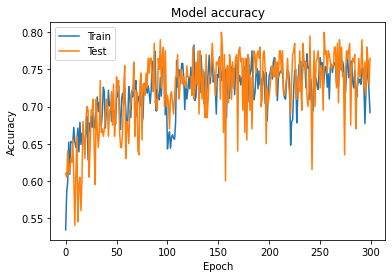

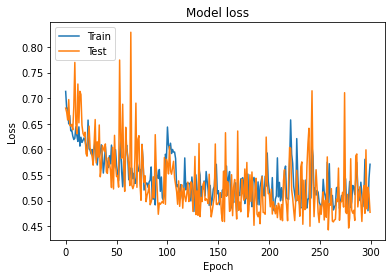

625/625 [==============================] - 1s 1ms/step


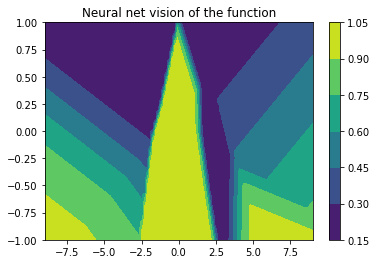

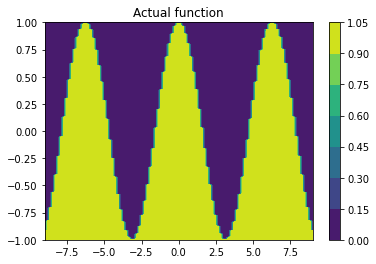

In [17]:
plot_accuracy(tab_hist[6][1])
plot_contour_graph(tab_model[6][1])